# Supplementary Material for Chilcare paper

## Hierarchical Generalized linear model

To determine differences in bacterial abundance we utilized generalized linear modeling using the generalized Gaussian distribution. Here we describe the priors and show an example in _R_. As described in the article, $\sigma$ and $\alpha$ are estimated as a constant for each model whereas $\mu$ is predicted as a linear function as noted below. 


#### Likelihood function 
$y_i \sim N(\alpha, \mu_i, \sigma_i)$  
$\mu_i = \beta_0 + \beta_{0 subject[i]} + \beta_{1 subject[i]}Time + \beta_{2}CC + \beta_{3}Time\times CC + \beta_{4 subject[i]}Age + \beta_{5 subject[i]}BF$ 


$
\begin{bmatrix}
\beta_{0 subject[i]}  \\
\beta_{1 subject[i]}  \\
\beta_{4 subject[i]}  \\
\beta_{5 subject[i]} 
\end{bmatrix} \sim MVNormal\bigg( \begin{bmatrix}
\beta_{0}  \\
\beta_{1}  \\
\beta_{4}  \\
\beta_{5}
\end{bmatrix}, S\bigg)
$
$S = \begin{bmatrix}
\sigma_{\beta0} & 0 & 0 & 0 \\
0 & \sigma_{\beta1} & 0 & 0\\
0 & 0 & \sigma_{\beta4}  & 0\\
0 & 0 & 0 & \sigma_{\beta5}\\
\end{bmatrix} R \begin{bmatrix}
\sigma_{\beta0} & 0 & 0 & 0 \\
0 & \sigma_{\beta1} & 0 & 0\\
0 & 0 & \sigma_{\beta4}  & 0\\
0 & 0 & 0 & \sigma_{\beta5}\\
\end{bmatrix}$

In the above notation, $y_i$ referes to the outcome of bacterial abundance. The predictors *Time* and *CC* are both factors with 2 levels (CC vs HOME & PRE vs POST). The notation indicates that this is a multilevel model where the the intercept and the slope corresponding to the covariates as well as the $\beta$ for *Time* are varying per subject. This means that we need to define priors for the constant parameters $\alpha$ and $\sigma$ as well as the parameters described in the linear function. In the following the priors will be described. See comments after the "#".

#### Prior probabilities
$\sigma \sim T(3, 0, 10)$  *# Since the error term must be positive, in BRMS this refers to a half t-distribution*  
$\alpha \sim N(0, 4)$  
$\beta_0 \sim Normal(0, 10)$  *# Intercept*  
$\beta_{1-5} \sim Normal(0, 2)$ *# The effect of each predictor was expected to be 0 but this prior still easily gets overwhelmed by data*  
$\beta_{0 subject[i]} \sim Normal(0, \sigma_{subject})$  
$\sigma_{subject} \sim exp(25)$ *# This refers to the prior of the standard deviation of the varying effects. If a model did not converge, often a stronger prior was required. We expect very small effects for most slopes/differences + for most genera there is very little variation and therefore a strong regularizing prior was required to make the model converge. The following plot illustrates the probability that was assigned to the parameters sigma and how this translates to the expected between subject variation in respect to the slopes and intercepts.*  
$R \sim LKjcorr(2)$ # *prior for correlation matrix of varying effects*  



*BRMS* would use the default priors if you do not specify them beforehand. You check these default priors by defining the formula and passing it to the function _get_prior_:

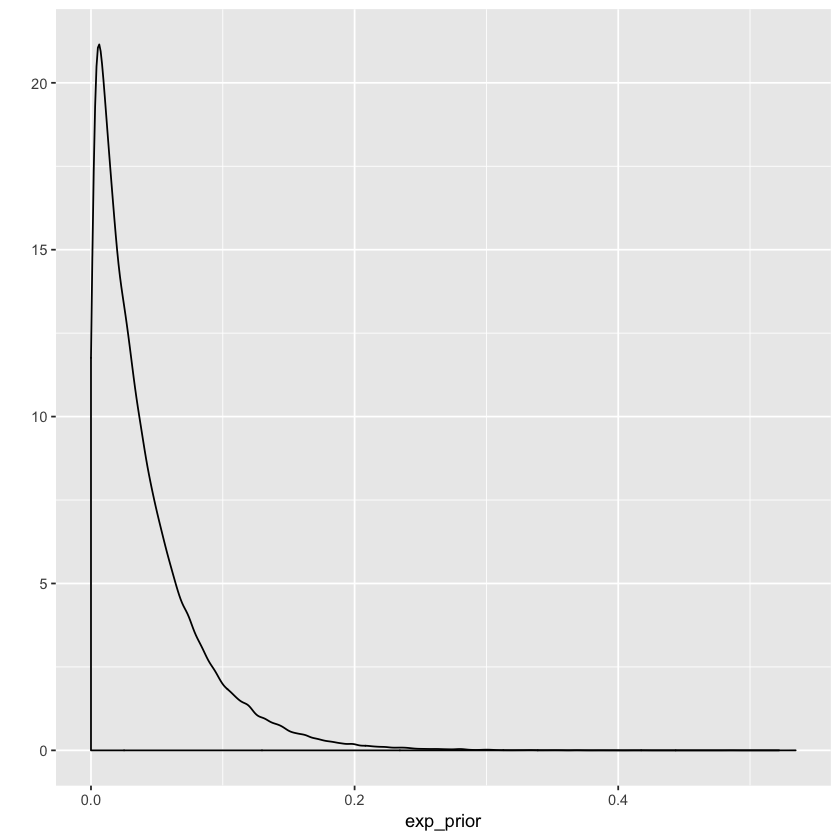

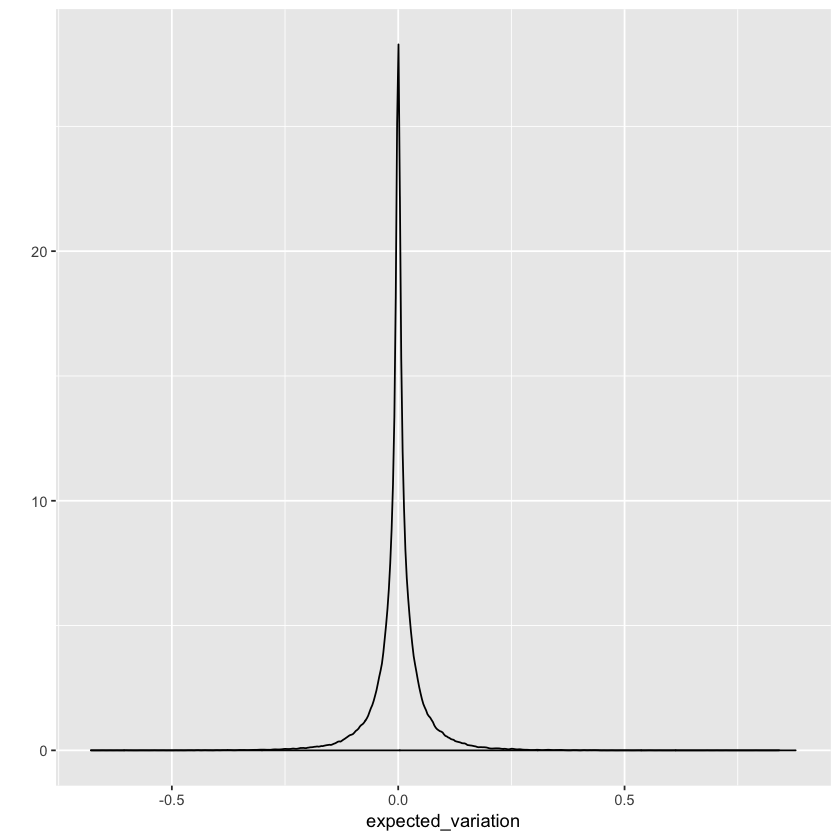

In [21]:
library(tidyverse)
library(brms)

# exponential prior
exp_prior <- rexp(rate = 25, n = 1e5)
expected_variation <- rnorm(mean = 0, sd = exp_prior, n = 1e5)
qplot(exp_prior, geom = "density")
qplot(expected_variation, geom = "density")


In [13]:
library(brms)
library(here)

# load data file
load(file = here("data/cc_analyses_workspace.RData"))
formula <- bf(Enterococcus ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id))
get_prior(formula, family = skew_normal(), data)

Warning message:
“Rows containing NAs were excluded from the model.”

prior,class,coef,group,resp,dpar,nlpar,bound
"student_t(3, 2, 10)",Intercept,,,,,,
"normal(0, 4)",alpha,,,,,,
,b,,,,,,
,b,age_d_s,,,,,
,b,bf_count_s,,,,,
,b,ccyes,,,,,
,b,timepost,,,,,
,b,timepost:ccyes,,,,,
lkj(1),cor,,,,,,
,cor,,subject_id,,,,


Usually, the prior is defined within the function *brm* or in this case *brm_multiple* since we used multiple imputation before and passed a list of 10 datasets into the function. We can also define the priors outside the brm function:

In [22]:
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("normal(0, 4)", class = "alpha"),
            set_prior("lkj(2)", class = "cor")
) 

In [24]:
fit <- brm_multiple(
    family = skew_normal(), data = data_imp, formula = formula, # data_imp is a list of 10 imputed datasets
    chains = 4, warmup = 1000, prior = prior,
    control = list(adapt_delta = 0.9999, max_treedepth = 15))

Fitting imputed model 1
Compiling the C++ model
Loading required package: phyloseq

Attaching package: ‘phyloseq’

The following object is masked from ‘package:brms’:

    nsamples

Start sampling



SAMPLING FOR MODEL '3130a9ce6b16d59a971f6ec58b67cc26' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000207 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.07 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 18.7747 seconds (Warm-up)
Chain 1:                13.5732 seconds (Sampling)
C

Fitting imputed model 2
Start sampling
Fitting imputed model 3
Start sampling
Fitting imputed model 4
Start sampling
Fitting imputed model 5
Start sampling
Fitting imputed model 6
Start sampling
Fitting imputed model 7
Start sampling
Fitting imputed model 8
Start sampling
Fitting imputed model 9
Start sampling
Fitting imputed model 10
Start sampling



SAMPLING FOR MODEL '3130a9ce6b16d59a971f6ec58b67cc26' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Gradient evaluated at the initial value is not finite.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Gradient evaluated at the initial value is not finite.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Gradient evaluated at the initial value is not finite.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: 
Chain 1: Gradient evaluation took 0.000112 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 200

In [25]:
# prior vs posterior
post <- posterior_samples(fit)
head(post)

b_Intercept,b_timepost,b_ccyes,b_age_d_s,b_bf_count_s,b_timepost:ccyes,sd_subject_id__Intercept,sd_subject_id__timepost,sd_subject_id__age_d_s,sd_subject_id__bf_count_s,⋯,"r_subject_id[437,bf_count_s]","r_subject_id[439,bf_count_s]","r_subject_id[442,bf_count_s]","r_subject_id[443,bf_count_s]","r_subject_id[446,bf_count_s]","r_subject_id[448,bf_count_s]","r_subject_id[449,bf_count_s]","r_subject_id[452,bf_count_s]","r_subject_id[453,bf_count_s]",lp__
2.163759,-0.04381940,0.03878454,0.2481768,-0.05838771,-0.32967160,0.01328489,0.036149210,0.040978635,0.053994879,⋯,0.048781685,0.0673286390,0.0874037354,-0.0150937460,0.0152998676,0.084552196,0.006348905,-0.003404680,-0.014018714,-920.1744
2.296835,-0.42482515,0.14559723,0.2326375,-0.13558601,0.09175085,0.03424598,0.003407547,0.038318983,0.022528032,⋯,-0.017495456,-0.0019406403,-0.0191250579,-0.0203428860,0.0003821835,-0.004720919,0.007700084,0.008563380,0.009123756,-928.2264
2.238181,0.08093422,0.08408184,0.2190599,-0.02060340,-0.40271682,0.05693590,0.123118563,0.015605122,0.012670395,⋯,-0.011887978,-0.0028992504,0.0298238736,-0.0221180224,0.0207329579,0.005285249,0.004895391,-0.007631204,-0.021912805,-912.9398
2.153115,0.00172056,0.20885894,0.1550168,-0.03636741,-0.19280523,0.05323804,0.017965341,0.008227876,0.003197782,⋯,-0.000537155,0.0003864751,0.0092149166,-0.0044195419,0.0019622823,0.001640136,0.001593562,-0.002495188,-0.002447746,-910.4482
1.917028,0.14401528,0.28505242,0.1723371,-0.05848407,-0.22850851,0.05067560,0.027392953,0.041651625,0.006512635,⋯,0.001489004,0.0081361700,0.0005644984,0.0009410425,-0.0145846236,-0.003972765,-0.002148918,0.008531420,0.001958768,-934.1054
2.513626,-0.32761157,-0.12622140,0.2445790,-0.11783406,0.04134767,0.03456743,0.034299510,0.069650109,0.048593656,⋯,-0.028745694,-0.1204319984,-0.0093940108,0.0288510266,0.0638150146,0.077786069,-0.077080281,0.007240528,-0.017039828,-925.5721


In [ ]:
ggplot(post, aes(sd_Intercept)) +
    geom_density() +
    geom_density(data = exp_prior, aes(exp_prior))

In [32]:
test <- readRDS(file = here("data/data_cc.rds"))

In [33]:
test

subject_id,time,cc,age_d,age_d_s,bf_count,bf_count_s,bf_ratio,groups,bf,⋯,Vibrio,Weissellaetrel,Wissellaetrel,Xanthomonadaceae,Yersiniaetrel,PC1,PC2,PC3,PC4,PC5
207,post,no,98.00,0.0320946,6.0000000,0.43948544,1.00000000,noCCpost,highBF,⋯,-0.108565400,-0.67915697,-1.784952,-1.1159447,-0.5359885,0.6522283,-5.032934404,3.70614262,2.1031823,-1.327350002
388,post,yes,98.00,0.0320946,0.0000000,-1.65710371,0.00000000,CCpost,lowBF,⋯,-0.480586139,-0.63054006,-1.871706,-1.1035981,-0.4674372,2.1772306,2.222413749,-1.14427625,-0.3484239,-0.113417746
381,post,yes,108.00,0.5275689,6.5900000,0.64565004,1.00000000,CCpost,highBF,⋯,-0.589353063,-0.76588701,-2.065653,-1.1978358,-0.6346224,-3.8048064,-3.362394476,0.04934941,5.5918159,-0.162220146
283,post,yes,107.03,0.4795079,5.0000000,0.09005391,1.00000000,CCpost,highBF,⋯,-0.418453304,-0.64204974,-1.821146,-0.9773729,-0.3960812,0.5556692,-1.347500353,-2.29104594,-0.4959173,0.507627877
216,post,no,100.00,0.1311895,7.0000000,0.78891696,1.00000000,noCCpost,highBF,⋯,-0.390162683,-0.66813066,-1.779084,-0.9487541,-0.3955235,0.5538176,-2.336839210,-0.05733428,-0.4504191,-0.049010236
277,pre,yes,79.00,-0.9093066,6.1000000,0.47442859,1.00000000,CCpre,highBF,⋯,-0.071065627,-0.60915747,-1.718924,-0.6601454,-0.2722899,0.2194641,-3.135663857,0.50348344,-0.4307532,0.462030858
373,post,no,113.00,0.7753060,6.0000000,0.43948544,0.88888889,noCCpost,highBF,⋯,-0.361702995,-0.51666239,-1.781343,-0.8140675,-0.3748642,1.6423095,0.004707199,1.39476114,-0.1227195,0.860300720
245,pre,no,68.00,-1.4543283,6.7611111,0.70544165,0.98050274,noCCpre,highBF,⋯,-0.005022927,-0.46916777,-2.100328,0.6002349,3.2915605,-7.5754909,7.674965721,1.32553640,-3.2160720,-1.906818621
311,pre,no,75.00,-1.1074963,7.2000000,0.85880327,0.98630137,noCCpre,highBF,⋯,-0.411625687,-0.65865661,-1.908299,-0.9779432,0.5955644,-3.3655963,1.922474020,2.95647775,-1.6068311,1.563697497
213,pre,yes,88.00,-0.4633797,6.4583333,0.59964155,0.96273292,CCpre,highBF,⋯,-0.388141717,-0.46072343,-1.815413,-0.7706038,-0.3736397,2.0631796,1.431105233,3.02043933,0.7779362,0.230197037
